# Physics informed Bayesian network  for matching process / variable / performance in solar cells.

This notebook introduces a 2-step Bayesian inference method (Bayesian network) to link process conditons to material descriptors, then to device experimental measurement.

Detailed information about the model structure are from the following paper:

*Ren and Oveido et.al , Physics-guided characterization and optimization of solar cells using surrogatemachine learning model, IEEE PVSC46, 2019*

*Ren and Oveido et.al , Embedding Physics Domain Knowledge into a Bayesian Network Enables Layer-by-Layer Process Innovation for Photovoltaics, npj Computational Materials 6 (1), 1-9* 

Below shows the schematic of our Bayesian-network-based process-optimization model, featuring a
two-step Bayesian inference that first links process conditions to materials descriptors, then the latter to device performance

![title](./Pictures/1.PNG)

The model consists of two main parts:
#### 1. CNN Surrogate model for denoising experimental JV curves and predicting JV curves from material descriptors 
#### 2. Two step Bayesian inference(Bayesian network) to map process conditions to material properties


We will show how the surrogate model works first. 
The surrogate models replaces numerical PDE with NN that enables >100x accelerating in computation speed and capability of handling noisy data. Model schematic are shown below.

![title](./Pictures/2.PNG)

#### 1. NN Surrogate model for denoising experimental JV curves and predicting JV curves from material descriptors 



##### Libraries and dependencies:

In [1]:
from keras import backend as K
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dense, Lambda,Conv1D,Conv2DTranspose, LeakyReLU,Activation,Flatten,Reshape
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from emcee import PTSampler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "calibri"


Using TensorFlow backend.
C:\Users\User\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\gpu\lib\site-packages\tenso

##### Load data and preprocess

In [2]:
# Load simulated and unormalized JV dataset
JV_raw = np.loadtxt('./Dataset/GaAs_sim_nJV.txt')

# Load material parameters that generated the JV dataset
par = np.loadtxt('./Dataset/GaAs_sim_label.txt')



def Conv1DTranspose(input_tensor, filters, kernel_size, strides ):
    
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1),padding='SAME')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#Covert labels from log10 form to log
        
def log10_ln(x):
    return np.log(np.power(10,x))

par = log10_ln(par)


#Data normalization for the whole JV dataset

def min_max(x):
    min = np.min(x)
    max = np.max(x)
    return (x-min)/(max-min),max,min

#Normalize raw JV data

JV_norm,JV_max,JV_min = min_max(JV_raw)

#Normalize JV descriptors column-wise
scaler = MinMaxScaler()

par_n = scaler.fit_transform(par)   

#create training and testing datset

X_train, X_test, y_train, y_test = train_test_split(JV_norm,par_n, test_size=0.2)

#add in Gaussian noise to train the denoising Autoencoder

X_train_nos = X_train+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 

X_test_nos = X_test+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)


Let's take a look at our data

Text(0, 0.5, 'current(a.u.)')

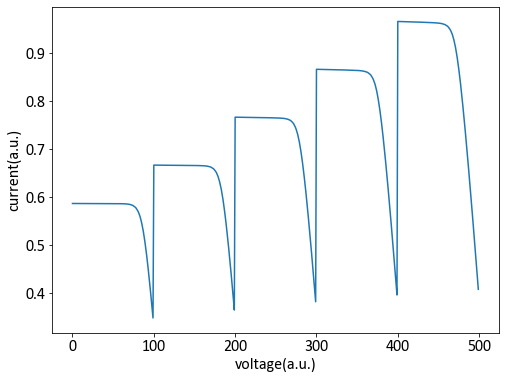

In [3]:
plt.plot(X_train[0,:])
plt.xlabel('voltage(a.u.)')
plt.ylabel('current(a.u.)')

##### build the denosiing Autoencoder

In [4]:

input_dim = X_train.shape[1]
label_dim = y_train.shape[1]
#JVi dim
x = Input(shape=(input_dim,))
#materail descriptor dim
y = Input(shape =(label_dim,))

# Network Parameters
max_filter = 256
strides = [5,2,2]
kernel = [7,5,3]
Batch_size = 128

#build the encoder
def encoder(x):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)    
    en0 = Conv1D(max_filter//4,kernel[0],strides= strides[0], padding='SAME')(x)
    en0 = LeakyReLU(0.2)(en0)
    en1 = Conv1D(max_filter//2,kernel[1],strides=strides[1], padding='SAME')(en0)
    en1 = LeakyReLU(0.2)(en1)
    en2 = Conv1D(max_filter,kernel[2], strides=strides[2],padding='SAME')(en1)
    en2 = LeakyReLU(0.2)(en2)
    en3 = Flatten()(en2)
    en3 = Dense(100,activation = 'relu')(en3)
    z = Dense(label_dim,activation = 'linear')(en3) 
    
    return z

z = encoder(x)
encoder_ = Model(x,z)
map_size = K.int_shape(encoder_.layers[-4].output)[1]

#build the decoder
z1 = Dense(100,activation = 'relu')(z)
z1 = Dense(max_filter*map_size,activation='relu')(z1)
z1 = Reshape((map_size,1,max_filter))(z1)
z2 =  Conv2DTranspose( max_filter//2, (kernel[2],1), strides=(strides[2],1),padding='SAME')(z1)
z2 = Activation('relu')(z2)
z3 = Conv2DTranspose(max_filter//4, (kernel[1],1), strides=(strides[1],1),padding='SAME')(z2)
z3 = Activation('relu')(z3)
z4 = Conv2DTranspose(1, (kernel[0],1), strides=(strides[0],1),padding='SAME')(z3)
decoded_x = Activation('sigmoid')(z4)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2))(decoded_x)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2))(decoded_x)

#Denoising autoencoder
ae = Model(inputs= x,outputs= decoded_x)

#ae loss
def ae_loss(x, decoded_x):      
    ae_loss = K.mean(K.sum(K.square(x- decoded_x),axis=-1))          
    return ae_loss

ae.compile(optimizer = 'adam', loss= ae_loss)
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                                      patience=5, min_lr=0.00001)
ae.fit(X_train_nos,X_train,shuffle=True, 
        batch_size=128,epochs = 50,
        validation_split=0.0, validation_data=None, callbacks=[reduce_lr])





Epoch 1/50
15999/15999 [==============================] - 2s 127us/step - loss: 3.0942
Epoch 2/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.5211
Epoch 3/50
15999/15999 [==============================] - 1s 45us/step - loss: 0.1093
Epoch 4/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0891
Epoch 5/50
15999/15999 [==============================] - 1s 45us/step - loss: 0.0852
Epoch 6/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0744
Epoch 7/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0457
Epoch 8/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0249
Epoch 9/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0147
Epoch 10/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0139
Epoch 11/50
15999/15999 [==============================] - 1s 46us/step - loss: 0.0137
Epoch 12/50
15999/15999 [=========================

plot the nosiy JVi and reconstructed JVi

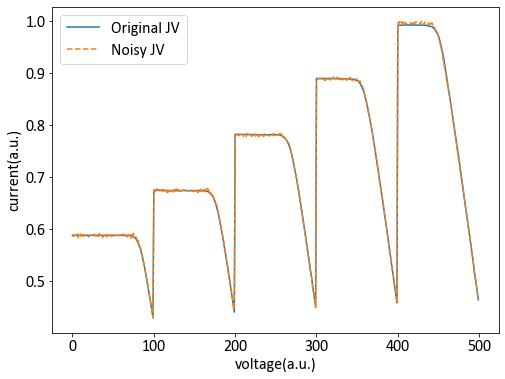

In [12]:
x_test_decoded= ae.predict(X_test_nos)
rand_ind = np.random.randint(0,100)
plt.plot(x_test_decoded[rand_ind,:],label='Original JV')
plt.plot(X_test_nos[rand_ind,:],'--',label='Noisy JV')
plt.xlabel('voltage(a.u.)')
plt.ylabel('current(a.u.)')
plt.legend()
plt.show()

##### build the regression model using the same structure of decoder


In [7]:
z_in = Input(shape=(label_dim,))
z1 = Dense(100,activation = 'relu')(z_in)
z1 = Dense(max_filter*map_size,activation='relu')(z1)
z1 = Reshape((map_size,1,max_filter))(z1)
z2 =  Conv2DTranspose( max_filter//2, (kernel[2],1), strides=(strides[2],1),padding='SAME')(z1)
z2 = Activation('relu')(z2)
z3 = Conv2DTranspose(max_filter//4, (kernel[1],1), strides=(strides[1],1),padding='SAME')(z2)
z3 = Activation('relu')(z3)
z4 = Conv2DTranspose(1, (kernel[0],1), strides=(strides[0],1),padding='SAME')(z3)
decoded_x = Activation('sigmoid')(z4)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2))(decoded_x)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2))(decoded_x)
reg = Model(z_in,decoded_x)
reg.compile(loss='mse',optimizer='adam')
reg.fit(y_train,X_train,shuffle=True,batch_size=128,epochs = 50,
            validation_split=0.0, validation_data=None)




Epoch 1/50
15999/15999 [==============================] - 1s 38us/step - loss: 0.0102
Epoch 2/50
15999/15999 [==============================] - 0s 25us/step - loss: 5.4077e-04
Epoch 3/50
15999/15999 [==============================] - 0s 25us/step - loss: 2.3316e-04
Epoch 4/50
15999/15999 [==============================] - 0s 25us/step - loss: 1.5393e-04
Epoch 5/50
15999/15999 [==============================] - 0s 25us/step - loss: 1.1547e-04
Epoch 6/50
15999/15999 [==============================] - 0s 25us/step - loss: 8.0755e-05
Epoch 7/50
15999/15999 [==============================] - 0s 25us/step - loss: 7.0392e-05
Epoch 8/50
15999/15999 [==============================] - 0s 25us/step - loss: 5.8406e-05
Epoch 9/50
15999/15999 [==============================] - 0s 27us/step - loss: 4.7259e-05
Epoch 10/50
15999/15999 [==============================] - 0s 25us/step - loss: 3.8252e-05
Epoch 11/50
15999/15999 [==============================] - 0s 25us/step - loss: 3.4943e-05
Epoch 12/50


In [8]:
y_hat_train = reg.predict(y_train)
y_hat_test = reg.predict(y_test)


#voltage sweep
v_sweep = np.linspace (0,1.1,100)

v_total =np.tile(v_sweep,5).reshape(1,-1)


mse = mean_squared_error
mse_train = mse(y_hat_train,X_train)
mse_test = mse(y_hat_test,X_test)

print ('train mse: %.6f' % (mse_train))
print ('test mse: %.6f' % (mse_test))



train mse: 0.000011
test mse: 0.000012


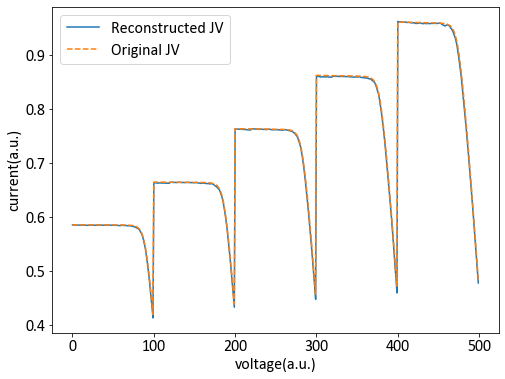

In [13]:
rand_ind = np.random.randint(0,100)
plt.plot(y_hat_test[rand_ind,:],label='Reconstructed JV')
plt.plot(X_test[rand_ind,:],'--',label='Original JV')
plt.xlabel('voltage(a.u.)')
plt.ylabel('current(a.u.)')
plt.legend()
plt.show()

save the denoised AE and regression model

In [15]:
ae.save('./TrainedModel/GaAs_AE.h5')
reg.save('./TrainedModel/GaAs_reg.h5')

#### 2. Two step Bayesian inference(Bayesian network) to map process conditions to materaal properties

Architecture of our Bayesian inference network, to identify new windows for process optimization.

![title](./Pictures/3.PNG)

##### Load process parameters and experimental data

In [16]:
#MOCVD growth tempearture

Temp = np.array([530,580,630,650,680])

#convert Tempearture to -1/T*1000 for Arrhenius equation input

x = -1000/(np.array(Temp))

In [17]:
JV_exp =np.loadtxt('./Dataset/GaAs_exp_nJV.txt')
par = np.loadtxt('./Dataset/GaAs_sim_label.txt')


Text(0, 0.5, 'current (a.u.)')

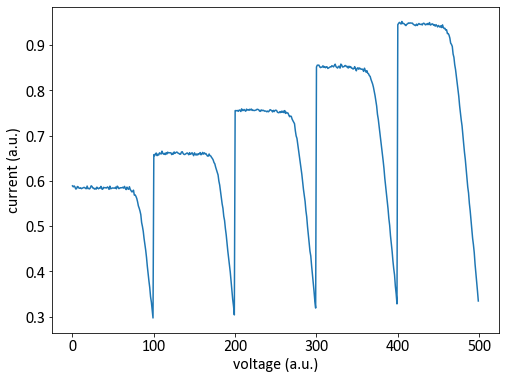

In [18]:
plt.plot(JV_exp[0,:])
plt.xlabel('voltage (a.u.)')
plt.ylabel('current (a.u.)')

denoise experimetnal JV using AE

Text(0, 0.5, 'current (a.u.)')

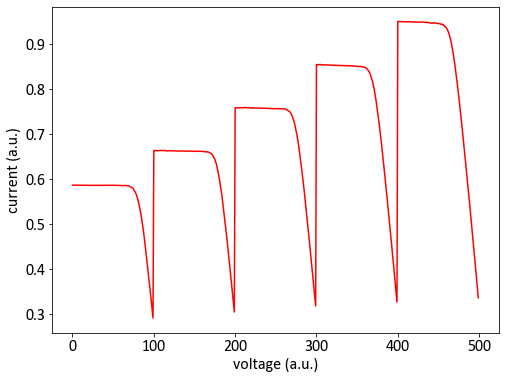

In [19]:
JV_exp = ae.predict(JV_exp)
plt.plot(JV_exp[0,:],color='red')
plt.xlabel('voltage (a.u.)')
plt.ylabel('current (a.u.)')

Preprocessing of data: Normalize JV descriptors column-wise

In [20]:
par_n = scaler.fit_transform(par)   

#####  Setting up MCMC for the two step Bayesian inference

Define the Bayesian inference frame work

In [21]:
#define the lognormal pdf

def log_norm_pdf(y,mu,sigma):
    return -0.5*np.sum((y-mu)**2/sigma)+np.log(sigma)

#define the logprobability based on Arrhenius equation 

     

##### Embedding domain knowledge to Prior in Bayesian inference

We parameterize the prior in Arrenhius equation form with a temperature dependent pre-exponential factor

We use the pretrained NN model as the likelihood function in Bayesian infernece framework

In [22]:
#define the lognormal pdf

def log_norm_pdf(y,mu,sigma):
    return -0.5*np.sum((y-mu)**2/sigma)+np.log(sigma)

#define the logprobability based on Arrhenius equation 

def log_probability(theta,x,y,sigma):
    a1,b1, c1, a2,b2,c2, a3,b3,c3, a4,b4,c4, a5,b5,c5 = theta
    emitter_doping = a1*np.log(-1/x)+b1*x+c1
    back_doping = a2*np.log(-1/x)+b2*x+c2
    tau = (a3*np.log(-1/x)+b3*x+c3)
    fsrv = (a4*np.log(-1/x)+b4*x+c4)
    rsrv = (a5*np.log(-1/x)+b5*x+c5)
       
    #stack all 5 materail descriptors
    par_input = 10*np.stack((emitter_doping,back_doping,tau,fsrv,rsrv),axis=-1)
    coeff = [a1,b1,c1,a2,b2,c2,a3,b3,c3,a4,b4,c4,a5,b5,c5]
    
    #setting prior and constraints
    if all(-10<x<10 for x in coeff) and max(np.abs(coeff[0::3]))<5:
    
        if np.max(par_input)<1 and np.min(par_input)>0:
            sim_curves= reg.predict(par_input)       
        
            return log_norm_pdf(sim_curves, y,sigma)
        return -np.inf
    return -np.inf
    
def logp(x):
    return 0.0 

Training Parameters

In [23]:
sigma = 1e-4
ntemp = 10
nruns = 2000
Temp_i = 0
#initialize the chian with a=0, b=0, c=0.5
pos = np.tile((0,0,0.5),5)/10+1e-4*np.random.randn(ntemp,64, 15)

ntemps, nwalkers, ndim = pos.shape

Perform the MCMC run


In [24]:
#first MCMC chain
sampler = PTSampler(ntemps,nwalkers, ndim, log_probability,logp, loglargs=(x, JV_exp, sigma))
sampler.run_mcmc(pos, nruns )
samples = sampler.chain

#use the values obtained in the first MCMC chain to update the inistal estimate
pos_update = samples[:,:,-1,:]+1e-5*np.random.randn(ntemp,64, 15)
sampler.reset()
#second MCM chain
sampler = PTSampler(ntemps,nwalkers, ndim, log_probability,logp, loglargs=(x, JV_exp, sigma))
sampler.run_mcmc(pos_update, nruns);
flat_samples = sampler.flatchain
zero_flat_samples = flat_samples[Temp_i,:,:]
zero_samples = samples[Temp_i,:,:,:]

Text(0, 0.5, 'loss')

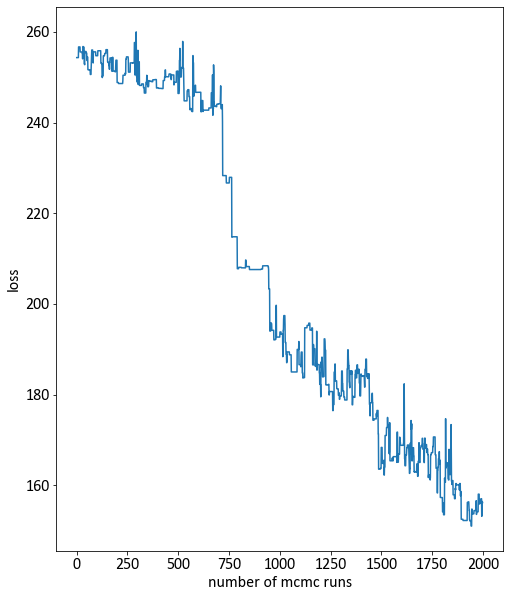

In [33]:
zero_flat_loss = sampler.lnprobability[Temp_i,:,:]
#visulize loss
plt.figure()
plt.plot(-1*zero_flat_loss[1,:])
plt.xlabel('number of mcmc runs')
plt.ylabel('loss')

Visulaization of parameters and loss

In [34]:
#function to show the predicted JV 
def check_plot(theta,x,sim):
    
    a1,b1, c1, a2,b2,c2, a3,b3,c3, a4,b4,c4, a5,b5,c5 = theta
    emitter_doping = a1*np.log(-1/x)+b1*x+c1
    back_doping = a2*np.log(-1/x)+b2*x+c2
    tau = (a3*np.log(-1/x)+b3*x+c3)
    fsrv = (a4*np.log(-1/x)+b4*x+c4)
    rsrv = (a5*np.log(-1/x)+b5*x+c5)

    
    
    par_input = 10*np.stack((emitter_doping,back_doping,tau,fsrv,rsrv),axis=-1)
    if sim == 0 :
        unnorm_par = scaler.inverse_transform(par_input)
        return par_input,unnorm_par
        
    sim_curves= reg.predict(par_input)
           
  
    return sim_curves, par_input



sim_JVs,_ = check_plot(flat_samples[Temp_i,-1,:],x,1)  

check the fitted JV curves

Text(0, 0.5, 'current (a.u.)')

<Figure size 576x576 with 0 Axes>

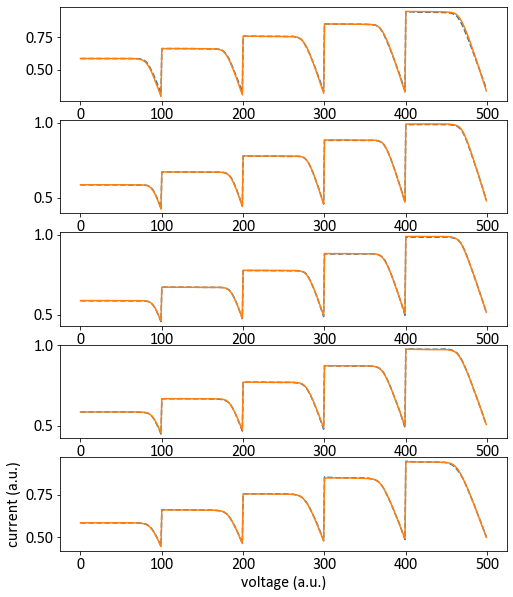

In [35]:
plt.figure(figsize = (8,8))
fig,ax = plt.subplots(5,1)
for i in range(5):
    ax[i,].plot(sim_JVs[i,:],'--')
    ax[i,].plot(JV_exp[i,:])

#Extract materail properties in a finer (-1/T) grid 
x_step = np.linspace(min(x),max(x),50)

par_in = []

for i in range(zero_flat_samples.shape[0]):
    _,par_input = check_plot(zero_flat_samples[i,:],x_step,0)
    
    par_in.append(par_input)
    
   
par_in= np.array(par_in)
#discard the values obtained at the begeinning of the chain
par_in = par_in[2000:,:,:]

par_in = (np.exp(par_in))

plt.xlabel('voltage (a.u.)')
plt.ylabel('current (a.u.)')


Plot materials parameters vs process conditions

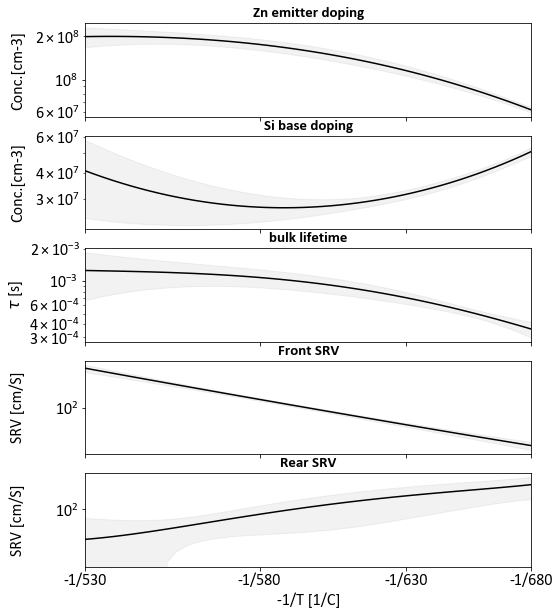

In [36]:
################################################################ 
#plotting the materail properties vs temperature 
################################################################

def plot_uncertain(x,y):
    
    mu = np.mean(y,axis = 0)
    std = np.std(y, axis = 0)
    plt.fill_between(x, mu+std,mu-std,alpha=0.1,color='grey')
    plt.plot(x,mu,color='black')

plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "calibri"    
fig = plt.figure()
y_label = ['Conc.[cm-3]','Conc.[cm-3]', r'$\tau$ [s]', 'SRV [cm/S]','SRV [cm/S]']
x_labels = ['-1/530' ,'-1/580','-1/630','-1/680']
title = ['Zn emitter doping' , 'Si base doping' ,'bulk lifetime','Front SRV', 'Rear SRV']


for i in range(5):
    plt.subplot(5,1,i+1)
    
    l1=plot_uncertain(x_step,par_in[:,:,i]) 
    plt.yscale('log') 
    plt.ylabel(y_label[i])
    plt.xticks([-1000/530,-1000/580,-1000/630,-1000/680],[])
    plt.title(title[i],fontsize=15,fontweight='bold')
    plt.xlim(-1000/530,-1000/680)
    
  
plt.xticks([-1000/530,-1000/580,-1000/630,-1000/680], x_labels)

plt.xlabel(r'-1/T [1/C]') 

fig.align_labels()